<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Diego Alberto López Lazareno,  Esteban Márquez Delgado.

**Fecha:** 14 de octubre del 2021.

**Expediente** : 722100, 700637.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
# Proyecto TEMA-2: Descarga de Datos

## Objetivo:

+ Descargar los datos fundamentales para las firmas financieras que forman parte del índice S&P $500$ con ayuda de la API de **Financial Modeling Prep**.

### Objetivos Específicos:

+ Descargar los datos fundamentales para los siguientes nodos: Margen de Beneficio Neto, Ratio Payout, Precio a Dividendos y Beta.
+ Filtrar los datos fundamentales con técnicas estadísticas.
+ Almacenar los datos fundamentales en un archivo de excel.


In [1]:
# Librerías necesarias
# Análisis y manejo de datos
import pandas as pd
import numpy as np

# Yfinance
import yfinance as yf

# Visualización
import matplotlib.pyplot as plt
%matplotlib inline

# Conexión a la API de Financial Modeling Prep
from pyfmpcloud import settings
from pyfmpcloud import company_valuation as cv
api_key = pd.read_csv("Data/apiKey_FMP.csv").iloc[0, 0]
settings.set_apikey(api_key)

# Filtrado de alertas
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Se obtienen las compañías listadas en el índice S&P 500 que pertenecen al sector financiero
sp500_companies = pd.DataFrame(pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0])
financialSector = sp500_companies[sp500_companies["GICS Sector"] == "Financials"]
# Símbolos de cotización
tickers = list(financialSector["Symbol"])

# Compañías financieras clasificadas por sub-industria
financialSector = pd.DataFrame(financialSector.groupby(["GICS Sub-Industry"])["GICS Sub-Industry"].count())
financialSector.loc["Total"] = financialSector.values.sum()
financialSector

,GICS Sub-Industry
GICS Sub-Industry,
Asset Management & Custody Banks,8
Consumer Finance,4
Diversified Banks,6
Financial Exchanges & Data,8
Insurance Brokers,5
Investment Banking & Brokerage,4
Life & Health Insurance,5
Multi-Sector Holdings,1
Multi-line Insurance,3


+ Existe un total de $65$ empresas del sector financiero que forman parte del índice S&P $500$.

In [3]:
## ------------------------------------------------ Configuraciones iniciales  --------------------------------------------- ##

# Función que calcula el margen de beneficio neto
f_netProfitMargin = lambda df : list(df["netIncome"] / df["revenue"])

# Función que calcula el ratio payout
f_ratioPayout = lambda df : list(abs(df["dividendsPaid"]) / df["netIncome"])

# Cálculo de Beta
def f_beta(ticker : "Símbolo de cotización", start : "Fecha de inicio", end : "Fecha final"):
    """
    f_beta devuelve la medida de volatilidad entre una acción relativa a al índice S&P 500, es decir, la Beta.
    
    ticker : Es el símbolo de cotización de una acción.
    start : Fecha de inicio para la descarga de precios históricos.
    end : Fecha de fin para la descarga de precios históricos.
    
    """
    # Descarga de precios históricos
    prices = pd.DataFrame()
    prices[ticker] = yf.download(ticker, start = start, end = end,  progress = False)["Adj Close"]
    prices["^GSPC"] = yf.download("^GSPC", start = start, end = end,  progress = False)["Adj Close"]
    
    # Cálculo de Beta
    CovMatrix = prices.dropna().pct_change().dropna().cov()
    beta = CovMatrix.iloc[0, 1] / CovMatrix.iloc[1, 1]
        
    return beta

def histogram(x : "Variable aleatoria", density = True, bins = 50, label = "Etiqueta", color = "Color"):
    """
    histogram devuelve el histograma de la variable aleatoria x.
    
    x: Variable aleatoria.
    density : Es la densidad de la distribución de probabilidad.
    bins : Es el número de categorías para el graficado del histograma, por defecto se establece en 50.
    label : Es el etiquetado para la visualización.
    color : Color del histograma.
    
    """
    plt.figure(figsize = (10, 5))
    plt.hist(x, bins = bins, density = density, label = label, color = color)
    plt.legend();
    
    
def filterByQuantiles(data : "Datos a filtrar", alpha = 0.05):
    """
    filterByQuantiles filtra una serie de datos, eliminando los valores que se encuentran en las colas de la distribución.
    
    data : Son los datos a filtrar.
    alpha: Es el nivel de significancia, por defecto se establece en 5%.
    
    """
    quantiles = np.quantile(data, [alpha, (1 - alpha)])
    filteredData = data[(data >= quantiles[0]) & (data <= quantiles[1])]
    
    return filteredData
    

## Nodos

### 1. Margen de Beneficio Neto

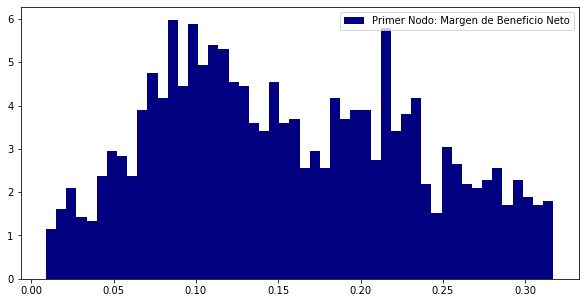

In [4]:
# Descarga de datos para la simulación del primer nodo
netProfitMargins = np.concatenate(list(map(lambda ticker : 
                                           f_netProfitMargin(cv.income_statement(ticker)[["revenue", "netIncome"]]), tickers)))

# Filtrado de datos
netProfitMargins = netProfitMargins[(netProfitMargins != float("inf")) & (netProfitMargins != float("-inf"))]
netProfitMargins = filterByQuantiles(netProfitMargins)

# Visualización
histogram(netProfitMargins, bins = 50, label = "Primer Nodo: Margen de Beneficio Neto", color = "navy")

### 2. Ratio Payout

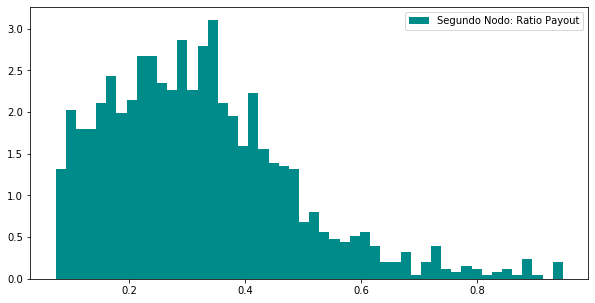

In [5]:
# Descarga de datos para la simulación del segundo nodo
payoutRatios = np.concatenate(list(map(lambda ticker : 
                                       f_ratioPayout(cv.cash_flow_statement(ticker)[["netIncome", "dividendsPaid"]]), tickers)))

# Filtrado de datos
payoutRatios = payoutRatios[(payoutRatios != float("inf")) & (payoutRatios != float("-inf")) & (payoutRatios > 0)]
payoutRatios = filterByQuantiles(payoutRatios)

# Visualización
histogram(payoutRatios, bins = 50, label = "Segundo Nodo: Ratio Payout", color = "darkcyan")

### 3. Precio a Dividendos

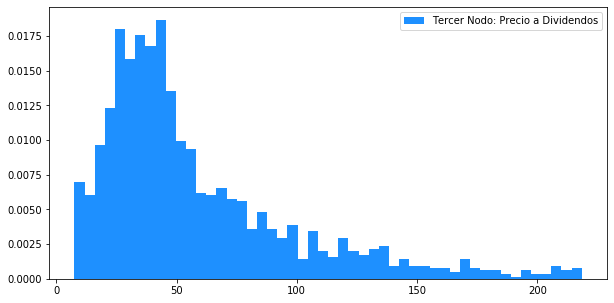

In [6]:
# Descarga de datos para la simulación del tercer nodo
priceToDividends = np.concatenate(list(map(lambda ticker : list(1 / cv.key_metrics(ticker)["dividendYield"]), tickers)))

# Filtrado de datos
priceToDividends = priceToDividends[(priceToDividends > 0)]
priceToDividends = filterByQuantiles(priceToDividends)

# Visualización
histogram(priceToDividends, bins = 50, label = "Tercer Nodo: Precio a Dividendos", color = "dodgerblue")

### 4. Beta

In [7]:
# Descarga de datos para la simulación del cuarto nodo
dates = [(str(i) + "-01-01", str(i) + "-12-31") for i in range(2010, 2021)]
betas = list(map(lambda date : list(map(lambda ticker : f_beta(ticker, date[0], date[1]), tickers)), dates))

# Filtrado de datos
betasDF = pd.DataFrame(np.concatenate(betas)).dropna()
betasFinancialSector = list(map(lambda i : float(betasDF.iloc[i]), range(len(betasDF))))
betasFinancialSector = filterByQuantiles(np.array(betasFinancialSector))


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- CFG: Data doesn't exist for startDate = 1262325600, endDate = 1293775200

1 Failed download:
- SYF: Data doesn't exist for startDate = 1262325600, endDate = 1293775200

1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- CFG: Data doesn't exist for startDate = 1293861600, endDate = 1325311200

1 Failed download:
- SYF: Data doesn't exist for startDate = 1293861600, endDate = 1325311200

1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- CFG: Data doesn't exist for startDate = 1325397600, endDate = 1356933600

1 Failed download:
- SYF: Data doesn't exist for startDate = 1325397600, endDate = 1356933600

1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- CFG: Data doesn't exist for startDate = 1357020000, endDate = 1388469600

1 Failed download:
- SYF: Data doesn't exist for startDate = 13570

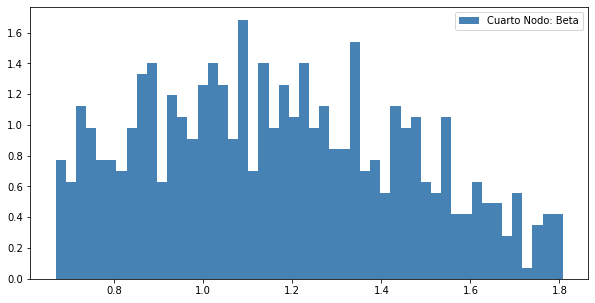

In [8]:
# Visualización
histogram(betasFinancialSector, bins = 50, label = "Cuarto Nodo: Beta", color = "steelblue")

In [9]:
# Almacenamiento de información en excel
pd.DataFrame(netProfitMargins).to_excel("Data/MargenNeto.xlsx", sheet_name = "Nodo1")
pd.DataFrame(payoutRatios).to_excel("Data/RatioPayout.xlsx", sheet_name = "Nodo2")
pd.DataFrame(priceToDividends).to_excel("Data/PrecioDividendos.xlsx", sheet_name = "Nodo3")
pd.DataFrame(betasFinancialSector).to_excel("Data/Betas.xlsx", sheet_name = "Nodo4")